In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential, Model, Input
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Dense

from keras.applications import resnet50, mobilenet
from keras.applications.mobilenet import preprocess_input

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.utils import to_categorical

import cv2

Using TensorFlow backend.


In [4]:
from imutils import paths
imagePaths = list(paths.list_images('dataset/'))
data = []
labels = []

In [7]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [9]:
labels

array(['dataset/without_mask', 'dataset/without_mask',
       'dataset/without_mask', ..., 'dataset/with_mask',
       'dataset/with_mask', 'dataset/with_mask'], dtype='<U20')

In [11]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [12]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [14]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [15]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [16]:
aug.fit(trainX)

In [17]:
mobilenet_model = mobilenet.MobileNet(input_shape = (224, 224, 3), weights='imagenet', include_top=False)

17227776/17225924 [==============================] - 8s 0us/step


In [22]:
#inputs  = mobilenet_model.input

inputs = Input(shape=(224, 224, 3))
x = mobilenet_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) # we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.5)(x) # to avoid overfitting
x = Dense(512, activation='relu')(x) # dense layer 2

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.layers[1].trainable = False

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1026

In [23]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32



# compile our model
from tensorflow.keras.optimizers import Adam
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [24]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 190s 6s/step - loss: 0.3317 - accuracy: 0.8642 - val_loss: 0.0864 - val_accuracy: 0.9674
Epoch 2/20
34/34 [==============================] - 146s 4s/step - loss: 0.0973 - accuracy: 0.9672 - val_loss: 0.0349 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 153s 5s/step - loss: 0.0512 - accuracy: 0.9813 - val_loss: 0.0303 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 144s 4s/step - loss: 0.0592 - accuracy: 0.9766 - val_loss: 0.0314 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 144s 4s/step - loss: 0.0523 - accuracy: 0.9794 - val_loss: 0.0319 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 145s 4s/step - loss: 0.0493 - accuracy: 0.9841 - val_loss: 0.0330 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 152s 4s/step - loss: 0.0331 - accuracy: 0.9860 - val_loss: 0.0355 - val_accura

In [32]:
from sklearn.metrics import classification_report

# make predictions on the testing set
print("evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))



evaluating network...
                      precision    recall  f1-score   support

   dataset/with_mask       0.99      0.99      0.99       138
dataset/without_mask       0.99      0.99      0.99       138

           micro avg       0.99      0.99      0.99       276
           macro avg       0.99      0.99      0.99       276
        weighted avg       0.99      0.99      0.99       276



In [33]:
# serialize the model to disk
print("saving mask detector model...")
model.save('face_mask_detector1.model.h5')

saving mask detector model...


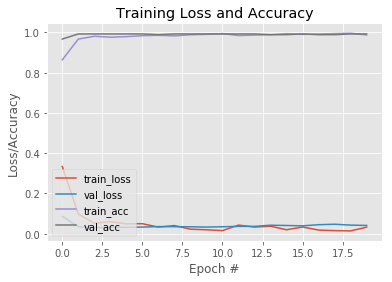

In [29]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()